In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, img_as_bool, morphology
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy import linalg, ndimage


def ridgeDetect(image, sigmas):
    image = color.rgb2gray(image)
    ridges = np.zeros(sigmas.shape + image.shape)

    # Filtering for all sigmas
    for i, sigma in enumerate(sigmas):        
        D = hessian_matrix(image, sigma, order='rc') # Make 2D hessian
        D = np.array(D) * (sigma ** 2)               # Correct for scale        
        lambda1, lambda2 = hessian_matrix_eigvals(D) # Calculate (abs sorted) eigenvalues and vectors
        ridges[i] = -lambda2 - np.abs(lambda1)       # Ridge strength
        
    # Max across all scales
    ridge = np.max(ridges, axis=0)    
    return ridge

def cleanFeature(feat, sigmas, threshold):
    # Clean edge effect
    mrg = 3*np.max(sigmas)
    feat[:mrg,  :] = 0
    feat[-mrg:, :] = 0
    feat[:, :mrg] = 0
    feat[:, -mrg:] = 0    
    # Clear below threshold
    feat[feat<threshold] = 0    
    return feat

def rootComponents(ridge, minSize, minElong):
    # Make Skeleton
    bin = img_as_bool(ridge>0)
    skel = morphology.medial_axis(bin)
    skel = morphology.dilation(skel)
    # Clean Components
    labeled, compCount = ndimage.label(skel)
    for i in np.arange(compCount):
        mask = labeled==i
        coors = np.argwhere(mask);
        if coors.shape[0] < minSize:
            skel[mask] = 0
            continue
        cov = np.cov(coors, rowvar=False)
        evals, evecs = linalg.eigh(cov)
        evals = np.abs(evals)
        if np.max(evals) < minElong * np.min(evals):
            skel[mask] = 0
    return skel


def justDoIt(image):
    # Basic multi-scale ridge detector
    sigmas = np.arange(1, 15, 2)
    threshold = 0.03    
    ridge = ridgeDetect(image, sigmas)
    cleaned = cleanFeature(ridge.copy(), sigmas, threshold)
    # Make skeleton and clean components
    minSize = 200
    minElong = 10
    roots = rootComponents(cleaned, minSize, minElong)
    return roots


In [3]:
def quantifyTotalLength(rootMask):
    return np.sum(rootMask)

In [4]:
def validate(im, maskA, maskB):
    fig = plt.figure(figsize=(20,10))
    fig.add_subplot(1,3,1), plt.imshow(im)
    fig.add_subplot(1,3,2), plt.imshow(morphology.dilation(maskA));
    fig.add_subplot(1,3,3), plt.imshow(morphology.dilation(maskB));
    # Quantify some measure of root quantity
    rootLenA = quantifyTotalLength(maskA)
    rootLenB = quantifyTotalLength(maskB)
    print('Length of roots in mask %d and in estimate %d' % (rootLenA, rootLenB))
    return rootLenA, rootLenB

Length of roots in mask 10872 and in estimate 39531
Length of roots in mask 111745 and in estimate 53249


(111745.0, 53249)

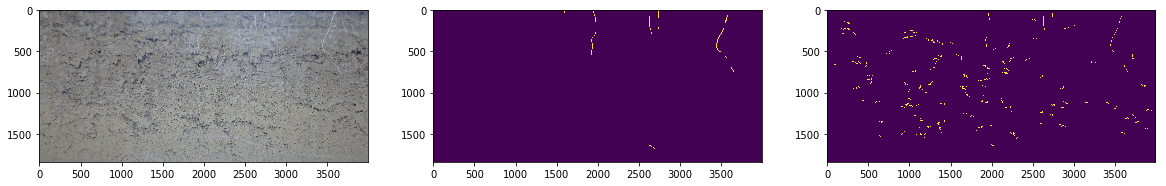

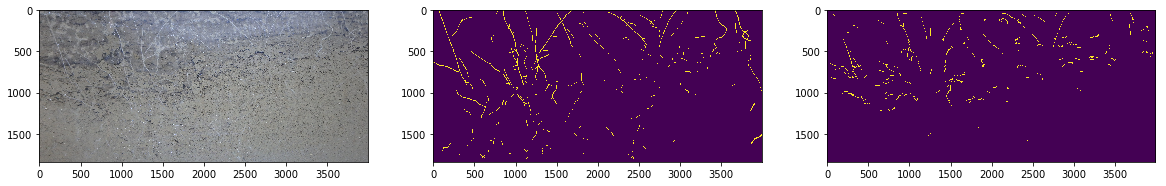

In [5]:
dirName = 'figure/'
fewImName = '16_06_21_10E11c_P6210609_photo'
fewAnName = '16_06_21_10E11c_P6210609_annotation'
manyImName = '16_07_18_11E8c_P7181734_photo'
manyAnName = '16_07_18_11E8c_P7181734_annotation'

fewIm = plt.imread(os.path.join(dirName, fewImName + '.png'))
fewAn = plt.imread(os.path.join(dirName, fewAnName + '.png'))
manyIm = plt.imread(os.path.join(dirName, manyImName + '.png'))
manyAn = plt.imread(os.path.join(dirName, manyAnName + '.png'))

validate(fewIm, fewAn, justDoIt(fewIm))
validate(manyIm, manyAn, justDoIt(manyIm))

Found 2 pictures
Detecting 0/2 ...
 Picture file:    /Users/erikdam/Dropbox (DIKU)/DataScienceLab/MLIM2019/Monday/Notebooks/16_06_21_10E11c_P6210609_photo.png
 Annotation file: /Users/erikdam/Dropbox (DIKU)/DataScienceLab/MLIM2019/Monday/Notebooks/16_06_21_10E11c_P6210609_annotation.png
 Expert and detection root lengths: 39531 vs 10872
Detecting 1/2 ...
 Picture file:    /Users/erikdam/Dropbox (DIKU)/DataScienceLab/MLIM2019/Monday/Notebooks/16_07_18_11E8c_P7181734_photo.png
 Annotation file: /Users/erikdam/Dropbox (DIKU)/DataScienceLab/MLIM2019/Monday/Notebooks/16_07_18_11E8c_P7181734_annotation.png
 Expert and detection root lengths: 53249 vs 111745
[[39531.]
 [53249.]]
[[ 10872.]
 [111745.]]
Linear correlation r2: -44.095556


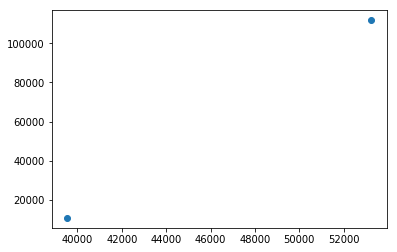

In [25]:
# Or a bit more general

import glob
from sklearn.metrics import r2_score

picDir = 'figure/'
pics = glob.glob(picDir + '*photo.png')
count = len(pics)
print("Found %d pictures" % count)
expertLen = np.zeros((count,1)) # Total root length for expert masks
detectLen = np.zeros((count,1)) # Total root length for detected masks
for i in range(count):
    print('Detecting %d/%d ...' % (i, count))
    fileName = pics[i]
    print(' Picture file:    %s' % fileName)
    pic = plt.imread(os.path.join(picDir, fileName))
    detect = justDoIt(pic)
    expertLen[i] = quantifyTotalLength(detect)
    fileName = fileName.replace('photo','annotation')
    print(' Annotation file: %s' % fileName)    
    ann = plt.imread(os.path.join(picDir, fileName))
    detectLen[i] = quantifyTotalLength(ann)
    print(' Expert and detection root lengths: %.0f vs %.0f' % (expertLen[i], detectLen[i]))

# Statistics: Correlation between expert and computer
print(expertLen)
print(detectLen)
r2 = r2_score(expertLen, detectLen)
plt.scatter(expertLen, detectLen)
print('Linear correlation r2: %f' % r2)